C:\Users\zhang\AppData\Local\Temp\ipykernel_45180\996993552.py:55: RuntimeWarning: divide by zero encountered in divide
  ucb = avg + np.sqrt(2*log_t/n_k)
C:\Users\zhang\AppData\Local\Temp\ipykernel_45180\996993552.py:58: RuntimeWarning: invalid value encountered in divide
  ucb = avg + np.sqrt(2*var*log_t/n_k) + 3*log_t/n_k
C:\Users\zhang\AppData\Local\Temp\ipykernel_45180\996993552.py:58: RuntimeWarning: divide by zero encountered in divide
  ucb = avg + np.sqrt(2*var*log_t/n_k) + 3*log_t/n_k
C:\Users\zhang\AppData\Local\Temp\ipykernel_45180\996993552.py:58: RuntimeWarning: invalid value encountered in sqrt
  ucb = avg + np.sqrt(2*var*log_t/n_k) + 3*log_t/n_k
C:\Users\zhang\AppData\Local\Temp\ipykernel_45180\996993552.py:61: RuntimeWarning: divide by zero encountered in divide
  var = np.minimum(var + np.sqrt(2*log_t/n_k), 0.25)
C:\Users\zhang\AppData\Local\Temp\ipykernel_45180\996993552.py:62: RuntimeWarning: divide by zero encountered in divide
  ucb = avg + np.sqrt(log_t*var/n_k)


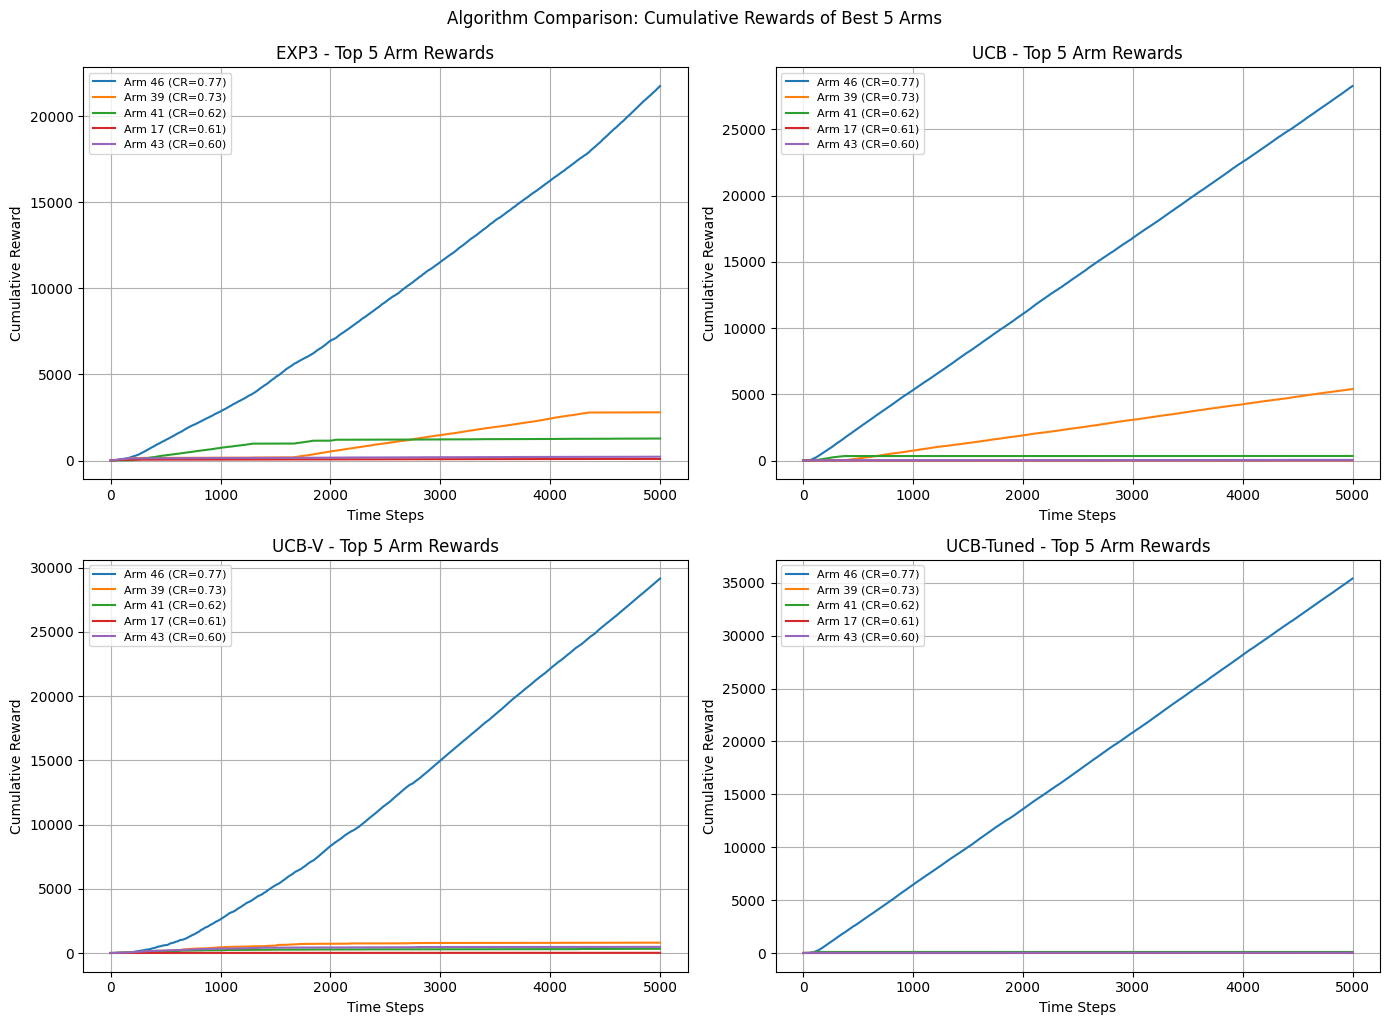

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

# ========================
# Simulation Parameters
# ========================
K = 50         # Increased arms for meaningful comparison
T = 5000       # Time horizon
n_agents = 5   # Independent runs
gamma = 0.2    # EXP3 exploration

# Generate environment with clear top 5 arms
np.random.seed(42)
price_options = np.linspace(0.1, 10.0, K)
conversion_rates = np.clip(np.random.beta(1, 5, K) + np.linspace(0, 0.4, K), 0, 1)
sorted_arms = np.argsort(conversion_rates)[::-1]
top5_arms = sorted_arms[:5]

# ========================
# Core Algorithm Implementations 
# ========================
def get_reward(price_index):
    return price_options[price_index] * (np.random.rand() < conversion_rates[price_index])

def run_algorithm(algorithm):
    """Returns cumulative rewards for top 5 arms (shape: 5 x T)"""
    top5_rewards = np.zeros((5, T))
    
    for _ in range(n_agents):
        # Algorithm state
        n_k = np.zeros(K)
        sum_r = np.zeros(K)
        sum_r2 = np.zeros(K)
        weights = np.ones(K)
        log_weights = np.zeros(K)
        cumulative_r = np.zeros(K)
        
        for t in range(T):
            if algorithm == "EXP3":
                # Numerically stable EXP3
                log_probs = log_weights - logsumexp(log_weights)
                probs = (1-gamma)*np.exp(log_probs) + gamma/K
                probs /= probs.sum()
                choice = np.random.choice(K, p=probs)
                reward = get_reward(choice)
                est_reward = reward/(probs[choice]+1e-8)
                log_weights[choice] += gamma * est_reward
            else:
                # UCB Family implementations
                avg = np.divide(sum_r, n_k, out=np.zeros(K), where=n_k>0)
                log_t = np.log(t+2)  # t+2 to avoid log(0)
                
                if algorithm == "UCB":
                    ucb = avg + np.sqrt(2*log_t/n_k)
                elif algorithm == "UCB-V":
                    var = np.divide(sum_r2, n_k, out=np.zeros(K), where=n_k>0) - avg**2
                    ucb = avg + np.sqrt(2*var*log_t/n_k) + 3*log_t/n_k
                elif algorithm == "UCB-Tuned":
                    var = np.divide(sum_r2, n_k, out=np.zeros(K), where=n_k>0) - avg**2
                    var = np.minimum(var + np.sqrt(2*log_t/n_k), 0.25)
                    ucb = avg + np.sqrt(log_t*var/n_k)
                
                ucb[n_k == 0] = np.inf
                choice = np.argmax(ucb)
                reward = get_reward(choice)
                
                # Update statistics
                n_k[choice] += 1
                sum_r[choice] += reward
                sum_r2[choice] += reward**2

            # Track cumulative rewards for top 5 arms
            cumulative_r += (np.arange(K) == choice) * reward
            top5_rewards[:, t] += cumulative_r[top5_arms]
    
    return top5_rewards / n_agents

# ========================
# Run All Algorithms & Plot
# ========================
algorithms = ["EXP3", "UCB", "UCB-V", "UCB-Tuned"]
results = {algo: run_algorithm(algo) for algo in algorithms}

# Create comparison plot
plt.figure(figsize=(14, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, algo in enumerate(algorithms, 1):
    plt.subplot(2, 2, idx)
    for arm_idx in range(5):
        plt.plot(results[algo][arm_idx], 
                 color=colors[arm_idx],
                 label=f'Arm {top5_arms[arm_idx]} (CR={conversion_rates[top5_arms[arm_idx]]:.2f})')
    
    plt.title(f"{algo} - Top 5 Arm Rewards")
    plt.xlabel("Time Steps")
    plt.ylabel("Cumulative Reward")
    plt.legend(loc='upper left', fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Algorithm Comparison: Cumulative Rewards of Best 5 Arms", y=1.02)
plt.show()

In [ ]:
# Original assignment 1
import numpy as np
import matplotlib.pyplot as plt

class DynamicPricingEnv:
    def __init__(self, prices, change_points, reward_probabilities):
        self.prices = prices
        self.change_points = change_points
        self.reward_probabilities = reward_probabilities
        self.current_phase = 0
        self.t = 0

    def step(self, price_index):
        if self.t in self.change_points:
            self.current_phase = min(self.current_phase + 1, len(self.reward_probabilities) - 1)
        self.t += 1
        return np.random.rand() < self.reward_probabilities[self.current_phase][price_index]

    def reset(self):
        self.current_phase = 0
        self.t = 0

class DiscountedUCB:
    def __init__(self, n_arms, gamma=0.99):
        self.n_arms = n_arms
        self.gamma = gamma
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        # TODO: Implement the arm selection logic for Discounted UCB
        return np.random.randint(self.n_arms)  # Temporary fallback to avoid error

    def update(self, arm, reward):
        # TODO: Implement the update rule for Discounted UCB
        pass

class SlidingWindowUCB:
    def __init__(self, n_arms, window_size=50):   # Default window size set to 50
        self.n_arms = n_arms
        self.window_size = window_size
        self.rewards = [[] for _ in range(n_arms)]

    def select_arm(self):
        # TODO: Implement the arm selection logic for Sliding Window UCB
        return np.random.randint(self.n_arms)  # Temporary fallback to avoid error

    def update(self, arm, reward):
        # TODO: Implement update rule for Sliding Window UCB
        pass

# Experiment Setup
prices = [5, 10, 15, 20]
change_points = [2000, 4000, 6000, 8000]
reward_probabilities = [
    [0.3, 0.5, 0.2, 0.1],  # Phase 1
    [0.2, 0.6, 0.3, 0.15], # Phase 2
    [0.1, 0.4, 0.5, 0.3],  # Phase 3
    [0.25, 0.35, 0.3, 0.2], # Phase 4
    [0.15, 0.5, 0.25, 0.4]  # Phase 5
]

env = DynamicPricingEnv(prices, change_points, reward_probabilities)
d_ucb = DiscountedUCB(len(prices))
sw_ucb = SlidingWindowUCB(len(prices))

T = 10000  # Total time steps
regrets_d = []
regrets_sw = []

for t in range(T):
    # Discounted UCB
    arm_d = d_ucb.select_arm()
    reward_d = env.step(arm_d)
    d_ucb.update(arm_d, reward_d)
    regrets_d.append(max(reward_probabilities[env.current_phase]) - reward_d)

    # Sliding Window UCB
    arm_sw = sw_ucb.select_arm()
    reward_sw = env.step(arm_sw)
    sw_ucb.update(arm_sw, reward_sw)
    regrets_sw.append(max(reward_probabilities[env.current_phase]) - reward_sw)

# Plot Regrets
plt.plot(np.cumsum(regrets_d), label='Discounted UCB')
plt.plot(np.cumsum(regrets_sw), label='Sliding Window UCB')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of Discounted UCB and Sliding Window UCB in Dynamic Pricing")
plt.show()


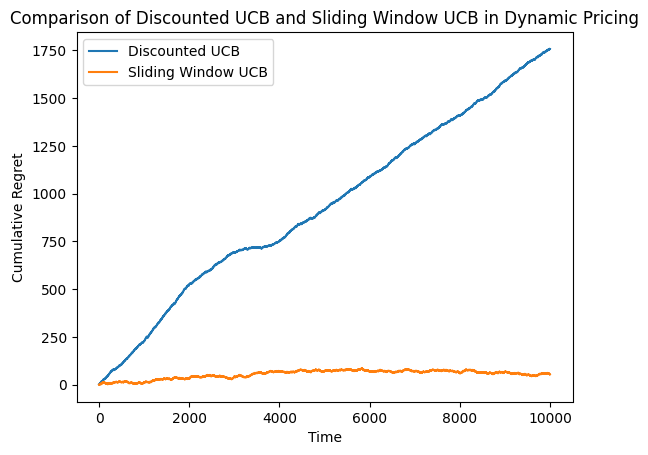

In [ ]:
# GPT assignment 1
import numpy as np
import matplotlib.pyplot as plt

class DynamicPricingEnv:
    def __init__(self, prices, change_points, reward_probabilities):
        self.prices = prices
        self.change_points = change_points
        self.reward_probabilities = reward_probabilities
        self.current_phase = 0
        self.t = 0

    def step(self, price_index):
        if self.t in self.change_points:
            self.current_phase = min(self.current_phase + 1, len(self.reward_probabilities) - 1)
        self.t += 1
        return np.random.rand() < self.reward_probabilities[self.current_phase][price_index]

    def reset(self):
        self.current_phase = 0
        self.t = 0

class DiscountedUCB:
    def __init__(self, n_arms, gamma=0.99):
        self.n_arms = n_arms
        self.gamma = gamma
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        total_counts = np.sum(self.counts)
        if total_counts == 0:
            return np.random.randint(self.n_arms)

        ucb_values = self.values + np.sqrt((2 * np.log(total_counts)) / (self.counts + 1e-6))
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts *= self.gamma
        self.counts[arm] += 1
        self.values[arm] = ((1 - self.gamma) * self.values[arm]) + (self.gamma * reward)

class SlidingWindowUCB:
    def __init__(self, n_arms, window_size=50):
        self.n_arms = n_arms
        self.window_size = window_size
        self.rewards = [[] for _ in range(n_arms)]

    def select_arm(self):
        ucb_values = []
        for i in range(self.n_arms):
            if len(self.rewards[i]) == 0:
                ucb_values.append(float('inf'))
            else:
                mean_reward = np.mean(self.rewards[i])
                confidence = np.sqrt((2 * np.log(sum(len(r) for r in self.rewards) + 1)) / len(self.rewards[i]))
                ucb_values.append(mean_reward + confidence)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.rewards[arm].append(reward)
        if len(self.rewards[arm]) > self.window_size:
            self.rewards[arm].pop(0)

# Experiment Setup
prices = [5, 10, 15, 20]
change_points = [2000, 4000, 6000, 8000]
reward_probabilities = [
    [0.3, 0.5, 0.2, 0.1],  # Phase 1
    [0.2, 0.6, 0.3, 0.15], # Phase 2
    [0.1, 0.4, 0.5, 0.3],  # Phase 3
    [0.25, 0.35, 0.3, 0.2], # Phase 4
    [0.15, 0.5, 0.25, 0.4]  # Phase 5
]

env = DynamicPricingEnv(prices, change_points, reward_probabilities)
d_ucb = DiscountedUCB(len(prices))
sw_ucb = SlidingWindowUCB(len(prices))

T = 10000  # Total time steps
regrets_d = []
regrets_sw = []

for t in range(T):
    # Discounted UCB
    arm_d = d_ucb.select_arm()
    reward_d = env.step(arm_d)
    d_ucb.update(arm_d, reward_d)
    regrets_d.append(max(reward_probabilities[env.current_phase]) - reward_d)

    # Sliding Window UCB
    arm_sw = sw_ucb.select_arm()
    reward_sw = env.step(arm_sw)
    sw_ucb.update(arm_sw, reward_sw)
    regrets_sw.append(max(reward_probabilities[env.current_phase]) - reward_sw)

# Plot Regrets
plt.plot(np.cumsum(regrets_d), label='Discounted UCB')
plt.plot(np.cumsum(regrets_sw), label='Sliding Window UCB')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of Discounted UCB and Sliding Window UCB in Dynamic Pricing")
plt.show()


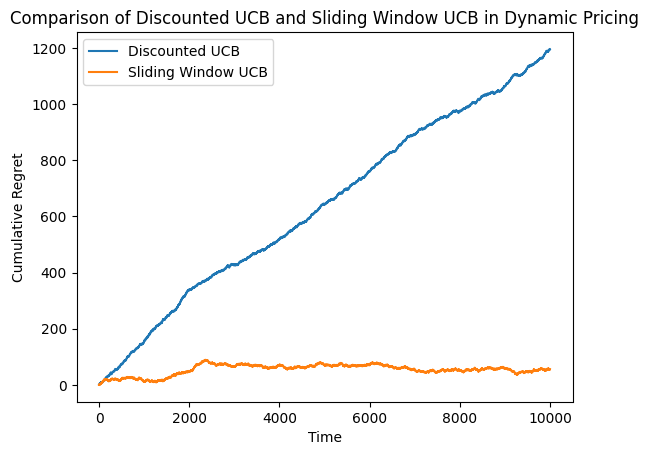

In [ ]:
# Deepseek assignment 1
import numpy as np
import matplotlib.pyplot as plt

class DynamicPricingEnv:
    def __init__(self, prices, change_points, reward_probabilities):
        self.prices = prices
        self.change_points = change_points
        self.reward_probabilities = reward_probabilities
        self.current_phase = 0
        self.t = 0

    def step(self, price_index):
        if self.t in self.change_points:
            self.current_phase = min(self.current_phase + 1, len(self.reward_probabilities) - 1)
        self.t += 1
        return np.random.rand() < self.reward_probabilities[self.current_phase][price_index]

    def reset(self):
        self.current_phase = 0
        self.t = 0

class DiscountedUCB:
    def __init__(self, n_arms, gamma=0.99):
        self.n_arms = n_arms
        self.gamma = gamma
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        total = np.sum(self.counts)
        ucb_values = (self.values / self.counts) + np.sqrt((2 * np.log(total)) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts *= self.gamma
        self.values *= self.gamma
        self.counts[arm] += 1
        self.values[arm] += reward

class SlidingWindowUCB:
    def __init__(self, n_arms, window_size=50):
        self.n_arms = n_arms
        self.window_size = window_size
        self.rewards = [[] for _ in range(n_arms)]

    def select_arm(self):
        for arm in range(self.n_arms):
            if len(self.rewards[arm]) == 0:
                return arm
        total_pulls = sum(len(rewards) for rewards in self.rewards)
        ucb_values = []
        for arm in range(self.n_arms):
            cnt = len(self.rewards[arm])
            avg = sum(self.rewards[arm]) / cnt
            ucb = avg + np.sqrt((2 * np.log(total_pulls)) / cnt)
            ucb_values.append(ucb)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.rewards[arm].append(reward)
        if len(self.rewards[arm]) > self.window_size:
            self.rewards[arm].pop(0)

# Experiment Setup
prices = [5, 10, 15, 20]
change_points = [2000, 4000, 6000, 8000]
reward_probabilities = [
    [0.3, 0.5, 0.2, 0.1],  # Phase 1
    [0.2, 0.6, 0.3, 0.15], # Phase 2
    [0.1, 0.4, 0.5, 0.3],  # Phase 3
    [0.25, 0.35, 0.3, 0.2], # Phase 4
    [0.15, 0.5, 0.25, 0.4]  # Phase 5
]

env = DynamicPricingEnv(prices, change_points, reward_probabilities)
d_ucb = DiscountedUCB(len(prices))
sw_ucb = SlidingWindowUCB(len(prices))

T = 10000  # Total time steps
regrets_d = []
regrets_sw = []

for t in range(T):
    # Discounted UCB
    arm_d = d_ucb.select_arm()
    reward_d = env.step(arm_d)
    d_ucb.update(arm_d, reward_d)
    regrets_d.append(max(reward_probabilities[env.current_phase]) - reward_d)

    # Sliding Window UCB
    arm_sw = sw_ucb.select_arm()
    reward_sw = env.step(arm_sw)
    sw_ucb.update(arm_sw, reward_sw)
    regrets_sw.append(max(reward_probabilities[env.current_phase]) - reward_sw)

# Plot Regrets
plt.plot(np.cumsum(regrets_d), label='Discounted UCB')
plt.plot(np.cumsum(regrets_sw), label='Sliding Window UCB')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of Discounted UCB and Sliding Window UCB in Dynamic Pricing")
plt.show()

In [ ]:
# Original assignment 2
import numpy as np
import matplotlib.pyplot as plt

# Bandit Environment
class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])  # Bernoulli rewards

# ==========================
# Fixed Exploration Then Exploitation (TODO: Implement switching strategy)
# ==========================
class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ TODO: Implement fixed exploration for N steps, then greedy """
        pass

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Epsilon-Greedy Algorithm (TODO: Complete update function)
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        """ TODO: Implement selection rule """
        pass

    def update(self, arm, reward):
        """ TODO: Implement incremental mean update """
        pass

# ==========================
# Epsilon-Greedy with Decaying Exploration (TODO: Complete decay schedule and compare schedules)
# ==========================
class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule  # Function for epsilon_t
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ TODO: Implement selection rule """
        pass

    def update(self, arm, reward):
        """ TODO: Implement update rule including epsilon decay """
        pass

# ==========================
# UCB Algorithm (TODO: Complete selection function)
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ TODO: Implement UCB selection rule """
        pass

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Thompson Sampling Algorithm (TODO: Implement Thompson Sampling)
# ==========================
class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)

    def select_arm(self):
        """ TODO: Implement Thompson Sampling selection rule """
        pass

    def update(self, arm, reward):
        """ TODO: Implement update rule for Beta distribution """
        pass

# ==========================
# Experiment Runner
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

# ==========================
# Running Experiments
# ==========================
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)  # Linearly spaced rewards
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000

# Define epsilon schedule
def epsilon_schedule(t):
    return 1 / (t + 1)

# Plot setup
plt.figure(figsize=(10,5))

# Run and plot Fixed Exploration Then Exploitation
fixed_exploration_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': 100}, env, num_steps)
plt.plot(fixed_exploration_regret, label='Fixed Exploration')

# Run and plot ε-Greedy
epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': 0.1}, env, num_steps)
plt.plot(epsilon_greedy_regret, label='Epsilon-Greedy')

# Run and plot Decaying ε-Greedy
decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')

# Run and plot UCB
ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
plt.plot(ucb_regret, label='UCB')

# Run and plot Thompson Sampling
thompson_regret = run_experiment(ThompsonSampling, {'num_arms': num_arms}, env, num_steps)
plt.plot(thompson_regret, label='Thompson Sampling')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Bandit Algorithm Performance")
plt.show()

# ==========================
# Instructions for Students
# ==========================
print("TODO: Complete the missing functions for Fixed-Exploration-Greedy, Epsilon-Greedy, Decaying Epsilon-Greedy, UCB, and Thompson Sampling.")
print("TODO: Implement and compare different epsilon schedules (e.g., 1/t, 1/sqrt(t), log(t)/t). Discuss the impact on exploration and cumulative regret in your report.")
print("TODO: Answer the questions in the assignment and conduct the necessary experiments to answer them.")


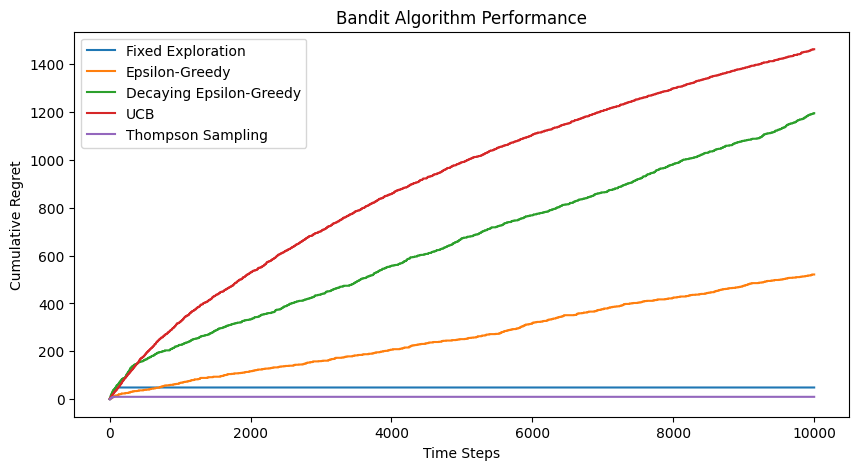

TODO: Complete the missing functions for Fixed-Exploration-Greedy, Epsilon-Greedy, Decaying Epsilon-Greedy, UCB, and Thompson Sampling.
TODO: Implement and compare different epsilon schedules (e.g., 1/t, 1/sqrt(t), log(t)/t). Discuss the impact on exploration and cumulative regret in your report.
TODO: Answer the questions in the assignment and conduct the necessary experiments to answer them.


In [ ]:
# GPT assignment 2
import numpy as np
import matplotlib.pyplot as plt

# Bandit Environment
class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])  # Bernoulli rewards

# ==========================
# Fixed Exploration Then Exploitation (TODO: Implement switching strategy)
# ==========================
class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ TODO: Implement fixed exploration for N steps, then greedy """
        if self.t <= self.exploration_steps:
            return np.random.randint(self.num_arms)  # Random exploration
        return np.argmax(self.values)  # Greedy exploitation

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Epsilon-Greedy Algorithm (TODO: Complete update function)
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        """ TODO: Implement selection rule """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)  # Explore
        return np.argmax(self.values)  # Exploit

    def update(self, arm, reward):
        """ TODO: Implement incremental mean update """
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

# ==========================
# Epsilon-Greedy with Decaying Exploration (TODO: Complete decay schedule and compare schedules)
# ==========================
class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule  # Function for epsilon_t
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ TODO: Implement selection rule """
        epsilon_t = self.epsilon_schedule(self.t)
        if np.random.rand() < epsilon_t:
            return np.random.randint(self.num_arms)  # Explore
        return np.argmax(self.values)  # Exploit

    def update(self, arm, reward):
        """ TODO: Implement update rule including epsilon decay """
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# UCB Algorithm (TODO: Complete selection function)
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ Implement UCB selection rule """
        total_counts = np.sum(self.counts)
        if total_counts < self.num_arms:  # Ensure each arm is tried at least once
            return int(total_counts)  # Explicitly cast to integer
        ucb_values = self.values + self.c * np.sqrt(np.log(total_counts) / (self.counts + 1e-6))
        return int(np.argmax(ucb_values))  # Ensure output is an integer


    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Thompson Sampling Algorithm (TODO: Implement Thompson Sampling)
# ==========================
class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)

    def select_arm(self):
        """ TODO: Implement Thompson Sampling selection rule """
        samples = [np.random.beta(self.successes[i] + 1, self.failures[i] + 1) for i in range(self.num_arms)]
        return np.argmax(samples)

    def update(self, arm, reward):
        """ TODO: Implement update rule for Beta distribution """
        if reward == 1:
            self.successes[arm] += 1
        else:
            self.failures[arm] += 1

# ==========================
# Experiment Runner
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

# ==========================
# Running Experiments
# ==========================
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)  # Linearly spaced rewards
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000

# Define epsilon schedule
def epsilon_schedule(t):
    return 1 / (t + 1)

# Plot setup
plt.figure(figsize=(10,5))

# Run and plot Fixed Exploration Then Exploitation
fixed_exploration_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': 100}, env, num_steps)
plt.plot(fixed_exploration_regret, label='Fixed Exploration')

# Run and plot ε-Greedy
epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': 0.1}, env, num_steps)
plt.plot(epsilon_greedy_regret, label='Epsilon-Greedy')

# Run and plot Decaying ε-Greedy
decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')

# Run and plot UCB
ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
plt.plot(ucb_regret, label='UCB')

# Run and plot Thompson Sampling
thompson_regret = run_experiment(ThompsonSampling, {'num_arms': num_arms}, env, num_steps)
plt.plot(thompson_regret, label='Thompson Sampling')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Bandit Algorithm Performance")
plt.show()

# ==========================
# Instructions for Students
# ==========================
print("TODO: Complete the missing functions for Fixed-Exploration-Greedy, Epsilon-Greedy, Decaying Epsilon-Greedy, UCB, and Thompson Sampling.")
print("TODO: Implement and compare different epsilon schedules (e.g., 1/t, 1/sqrt(t), log(t)/t). Discuss the impact on exploration and cumulative regret in your report.")
print("TODO: Answer the questions in the assignment and conduct the necessary experiments to answer them.")


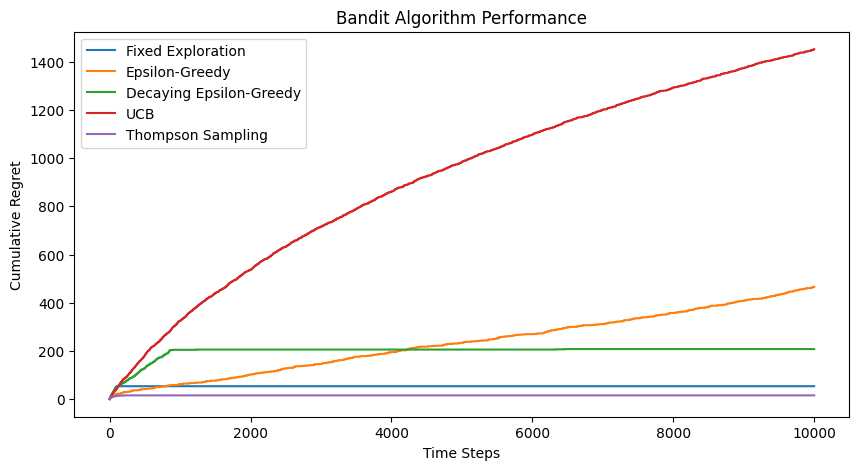

In [ ]:
# Deepseek assignment 2
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if self.t <= self.exploration_steps:
            return (self.t - 1) % self.num_arms
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        epsilon = self.epsilon_schedule(self.t)
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)

    def select_arm(self):
        samples = [np.random.beta(self.successes[arm] + 1, self.failures[arm] + 1) for arm in range(self.num_arms)]
        return np.argmax(samples)

    def update(self, arm, reward):
        if reward == 1:
            self.successes[arm] += 1
        else:
            self.failures[arm] += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

num_arms = 10
reward_means = np.linspace(0, 1, num_arms)
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000

def epsilon_schedule(t):
    return 1 / (t + 1)

plt.figure(figsize=(10,5))

fixed_exploration_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': 100}, env, num_steps)
plt.plot(fixed_exploration_regret, label='Fixed Exploration')

epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': 0.1}, env, num_steps)
plt.plot(epsilon_greedy_regret, label='Epsilon-Greedy')

decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')

ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
plt.plot(ucb_regret, label='UCB')

thompson_regret = run_experiment(ThompsonSampling, {'num_arms': num_arms}, env, num_steps)
plt.plot(thompson_regret, label='Thompson Sampling')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Bandit Algorithm Performance")
plt.show()

In [53]:
import numpy as np
import pandas as pd

# =================================================================
# Parameters (Baseline Configuration)
# =================================================================
N = 2                  # Number of LPs
rho = 0.5              # Correlation between LP measurement errors
omega = 0.15           # Volatility of LP measurement errors
omega_T = 0.13         # Volatility of trader's measurement error
s_T = 1.0              # Trader's reservation spread
delta = 1.0            # Probability of trader having liquidity demand (δ)
delta_B = 0.5          # Probability of buy vs. sell (δ_B)
T = 1000               # Number of time steps
np.random.seed(42)     # For reproducibility

# =================================================================
# Step 1: Simulate True Price Process (p_t*)
# =================================================================
def simulate_true_price(T, sigma=0.01):
    """True price follows a random walk with volatility sigma."""
    p_star = np.zeros(T)
    epsilon = np.random.normal(0, sigma, T)
    p_star = np.cumsum(epsilon)
    return p_star

p_star = simulate_true_price(T)

# =================================================================
# Step 2: Simulate LP and Trader Price Estimates (p_t^{(i)}, p_t^{(T)})
# =================================================================
def generate_measurement_errors(N, T, rho, omega):
    """Generate correlated measurement errors for LPs."""
    # Common factor (correlated component)
    common_factor = np.random.normal(0, np.sqrt(rho) * omega, T)
    # Idiosyncratic noise (independent component)
    idiosyncratic = np.random.normal(0, np.sqrt(1 - rho) * omega, (N, T))
    # Total measurement error: m^{(i)} = common_factor + idiosyncratic
    m_LP = common_factor + idiosyncratic
    return m_LP

# LP measurement errors (N x T matrix)
m_LP = generate_measurement_errors(N, T, rho, omega)

# Trader measurement error (1 x T vector)
m_T = np.random.normal(0, omega_T, T)

# LP mid-price estimates: p^{(i)} = p* + m^{(i)}
p_LP = p_star + m_LP

# Trader mid-price estimate: p^{(T)} = p* + m^{(T)}
p_T = p_star + m_T

# =================================================================
# Step 3: Simulate Trader Liquidity Demand (D_t)
# =================================================================
def simulate_trader_demand(T, delta, delta_B):
    """Generate trader's liquidity demand (D_t)."""
    A_t = np.random.binomial(1, delta, T)        # Demand indicator (δ)
    B_t = np.random.binomial(1, delta_B, T)      # Buy/sell indicator (δ_B)
    D_t = A_t * (2 * B_t - 1)                    # D_t ∈ {-1, 0, 1}
    return D_t

D_t = simulate_trader_demand(T, delta, delta_B)

# =================================================================
# Step 4: Simulate LP Quotes and Trade Execution
# =================================================================
def execute_trades(p_LP, p_T, D_t, s_LP, s_T):
    """Simulate trade execution based on best bid/ask prices."""
    N, T = p_LP.shape
    executed_trades = np.zeros((N, T))
    
    for t in range(T):
        if D_t[t] == 1:
            # Buy order: Trader takes best (lowest) ask price
            ask_prices = p_LP[:, t] + s_LP[:, t] / 2
            best_ask = np.min(ask_prices)
            if best_ask < (p_T[t] + s_T / 2):
                winning_LP = np.argmin(ask_prices)
                executed_trades[winning_LP, t] = 1
        elif D_t[t] == -1:
            # Sell order: Trader takes best (highest) bid price
            bid_prices = p_LP[:, t] - s_LP[:, t] / 2
            best_bid = np.max(bid_prices)
            if best_bid > (p_T[t] - s_T / 2):
                winning_LP = np.argmax(bid_prices)
                executed_trades[winning_LP, t] = -1
    return executed_trades

# Example: Assume all LPs quote a fixed spread (s_i = 0.5)
s_LP = np.full((N, T), 0.5)
executed_trades = execute_trades(p_LP, p_T, D_t, s_LP, s_T)

# =================================================================
# Step 5: Calculate Rewards (Effective Spread Capture)
# =================================================================
def calculate_rewards(p_star, p_LP, executed_trades, s_LP):
    """Compute LP rewards (effective spread +/- adverse selection)."""
    rewards = np.zeros((N, T))
    for i in range(N):
        for t in range(T):
            if executed_trades[i, t] == 1:
                # Effective spread on buy trade
                rewards[i, t] = (p_LP[i, t] + s_LP[i, t]/2 - p_star[t])
            elif executed_trades[i, t] == -1:
                # Effective spread on sell trade
                rewards[i, t] = (p_star[t] - (p_LP[i, t] - s_LP[i, t]/2))
    return rewards

rewards = calculate_rewards(p_star, p_LP, executed_trades, s_LP)